https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

In [22]:
import numpy as np
import pandas as pd
import networkx as nx
from random import shuffle
from itertools import permutations

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.spatial import Voronoi, voronoi_plot_2d

In [3]:
from sklearn.neighbors import NearestNeighbors

## Data

In [4]:
cols = ['X', 'Y', 'ID', 'NOMBRE', 'NIVEL']
schools = (pd.read_csv('./data/schools.csv', sep=';', usecols=cols)
             .rename(columns={'X': 'x', 'Y': 'y', 'ID': 'tag', 'NOMBRE': 'name', 'NIVEL': 'level'}))

In [5]:
schools = (schools.loc[schools.level.isin(['PRIMARIA', 'PRIMARIO'])]
                  .drop(columns=['level'])
                  .reset_index(drop=True)
)

In [6]:
cols = ['long', 'lat', 'id', 'nom_polid']
pools = (pd.read_csv('./data/pools.csv', usecols=cols)
           .rename(columns={'long': 'x', 'lat': 'y', 'id': 'tag', 'nom_polid': 'name'}))

## Voronoi y cercanos

In [11]:
pools_vor = np.array([[row['x'], row['y']] for i, row in pools.iterrows()])
schools_vor = np.array([[row['x'], row['y']] for i, row in schools.iterrows()])

In [12]:
vor = Voronoi(pools_vor)

In [13]:
colors_list = list(colors._colors_full_map.values())
shuffle(colors_list)

In [15]:
knn = NearestNeighbors(n_neighbors=1).fit(pools.loc[:, ['x', 'y']].values)

In [16]:
indeces = knn.kneighbors(schools.loc[:, ['x', 'y']].values, return_distance=False)

In [17]:
schools = schools.assign(closest = pools.loc[indeces.flatten(), 'tag'].values)

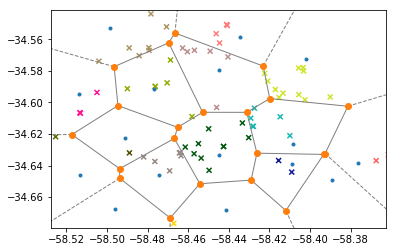

In [18]:
voronoi_plot_2d(vor, line_colors='grey')
plt.scatter(schools_vor[:,0], schools_vor[:,1],
            s=25, c=[colors_list[i] for i in schools.closest], marker='x')
plt.show()

## Graph

In [20]:
g = nx.Graph()

In [21]:
for i, node in schools.iterrows():
    g.add_node(node['name'], x=node['x'], y=node['y'], tipo='school')
    
for i, node in pools.iterrows():
    g.add_node(node['name'], x=node['x'], y=node['y'], tipo='pool')

In [45]:
def distance_between_pairs(node1, node2):
    """Returns euclidian distance between pairs of nodes"""
    node1_coords = schools.loc[schools.name==node1, ['x', 'y']].values[0]
    node2_coords = schools.loc[schools.name==node2, ['x', 'y']].values[0]
    return np.sqrt(np.sum(np.power(node1_coords - node2_coords, 2)))

In [ ]:
edges = []
groups = schools.closest.unique()

In [74]:
for group in groups:
    target_schools_name = list(permutations(schools.loc[schools.closest==group, 'name'].values, 2))
    
    for target in target_schools_name:
        distance = distance_between_pairs(*target)
        edges.append((*target, distance))

In [104]:
for group in groups:
    target_pool_name, *target_pool_coords = pools.loc[pools.tag==group, ['name', 'x', 'y']].values[0]
    
    for school in schools.loc[schools.closest==group, ['name', 'x', 'y']].values:
        target_school_name, *target_school_coords = school
        distance = np.sqrt(np.sum(np.power(np.array(target_pool_coords) - np.array(target_school_coords), 2)))
        edges.append((target_pool_name, target_school_name, distance))

In [106]:
for edge in edges:
    g.add_edge(edge[0], edge[1], distance=edge[2])

In [107]:
node_pos = {node[0]: (node[1]['x'], node[1]['y']) for node in g.nodes(data=True)}

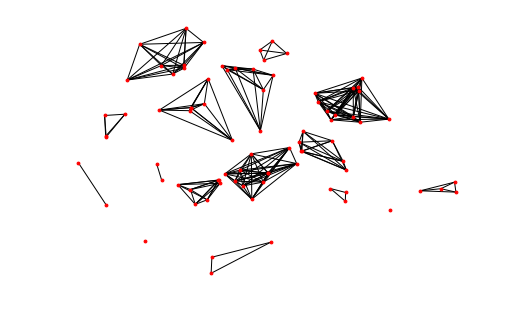

In [108]:
nx.draw(g, pos=node_pos, node_size=8, node_color='red')

In [54]:
def color(tipo):
    return 'black' if tipo=='school' else 'red'

In [60]:
node_pos = {node[0]: (node[1]['x'], node[1]['y']) for node in g.nodes(data=True)}

In [56]:
node_col = [color(node[1]['tipo']) for node in g.nodes(data=True)]

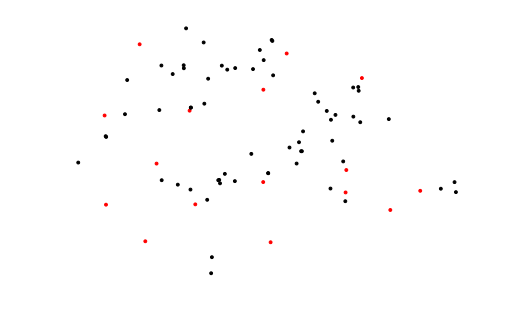

In [62]:
nx.draw(g, pos=node_pos, node_size=8, node_color=node_col)